In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# PART 1

### Import data

In [2]:
X_train = pd.read_csv("data/data_labeled/X_train.csv")
y_train = pd.read_csv("data/data_labeled/y_train.csv",header=None)
X_test = pd.read_csv("data/data_labeled/X_test.csv")
y_test = pd.read_csv("data/data_labeled/y_test.csv",header=None)

In [3]:
X_train

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,84,115.72,2.33,79.05,14.36,7.19,4.32,food production,High,High,Very high,37.82,123.06,heart_1466.png
1,137,110.72,2.25,125.24,16.53,7.44,4.29,services,Moderate,High,Very low,47.06,111.54,heart_128.png
2,105,102.65,2.74,123.59,10.91,7.42,4.06,food production,Very low,Moderate,High,25.79,100.03,heart_710.png
3,86,116.28,2.37,136.83,15.69,7.35,4.63,food production,Low,Very high,Low,22.36,85.09,heart_295.png
4,180,124.92,2.35,137.19,14.55,8.02,5.51,manufacturing,High,Very high,Moderate,16.58,116.05,heart_867.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,136,102.88,2.48,84.57,13.76,7.62,5.03,food production,High,High,Very low,33.41,104.34,heart_380.png
996,137,98.18,2.39,94.46,12.85,7.12,3.73,craftsmanship,Very high,High,Moderate,35.32,83.16,heart_1305.png
997,61,105.90,2.39,105.04,18.93,7.82,3.77,manufacturing,Moderate,Moderate,Moderate,38.44,98.39,heart_1202.png
998,120,105.34,2.36,79.08,20.88,7.71,5.28,food production,Low,Very low,Low,32.93,94.91,heart_672.png


### Categorical data processing

In [4]:

#tranform to 0-4 because labels have a sense of order
consumption_map = {"Very low":0, "Low":1, "Moderate":2, "High":3, "Very high":4}
X_train["sarsaparilla"] = X_train["sarsaparilla"].replace(consumption_map);
X_train["smurfberry liquor"] = X_train["smurfberry liquor"].replace(consumption_map);
X_train["smurfin donuts"] = X_train["smurfin donuts"].replace(consumption_map);
X_test["sarsaparilla"] = X_test["sarsaparilla"].replace(consumption_map);
X_test["smurfberry liquor"] = X_test["smurfberry liquor"].replace(consumption_map);
X_test["smurfin donuts"] = X_test["smurfin donuts"].replace(consumption_map);


#tranform professions into one-hot encoding because they don't have a sense of order
def one_hot_encode(data,column="profession"):
    categories = np.unique(data[column])
    for i in range(len(categories)): #pour chaque profession
        new_col = []
        for entry in data[column]: #pour chaque patient
            if entry == categories[i]:
                new_col.append(1) #Si la profession == profession du patient
            else:
                new_col.append(0) #Si non
        data.insert(len(data.columns),categories[i],new_col)
    data.drop(column,axis=1,inplace=True)
        
try:
	one_hot_encode(X_train)
	one_hot_encode(X_test)
except:
	print("Already processed")
     
#Drop pictures
X_train.drop("img_filename",axis=1,inplace=True)
X_test.drop("img_filename",axis=1,inplace=True)

## Normalization

In [5]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler()
scaled_X_train = normalizer.fit_transform(X_train)
scaled_X_test = normalizer.transform(X_test)

## Visualise tranformed dataset

(array([0, 1, 2, 3, 4]), array([272, 351, 170, 117,  90]))
(array([0, 1, 2, 3, 4]), array([ 80, 164, 351, 261, 144]))
(array([0, 1, 2, 3, 4]), array([187, 185, 219, 217, 192]))


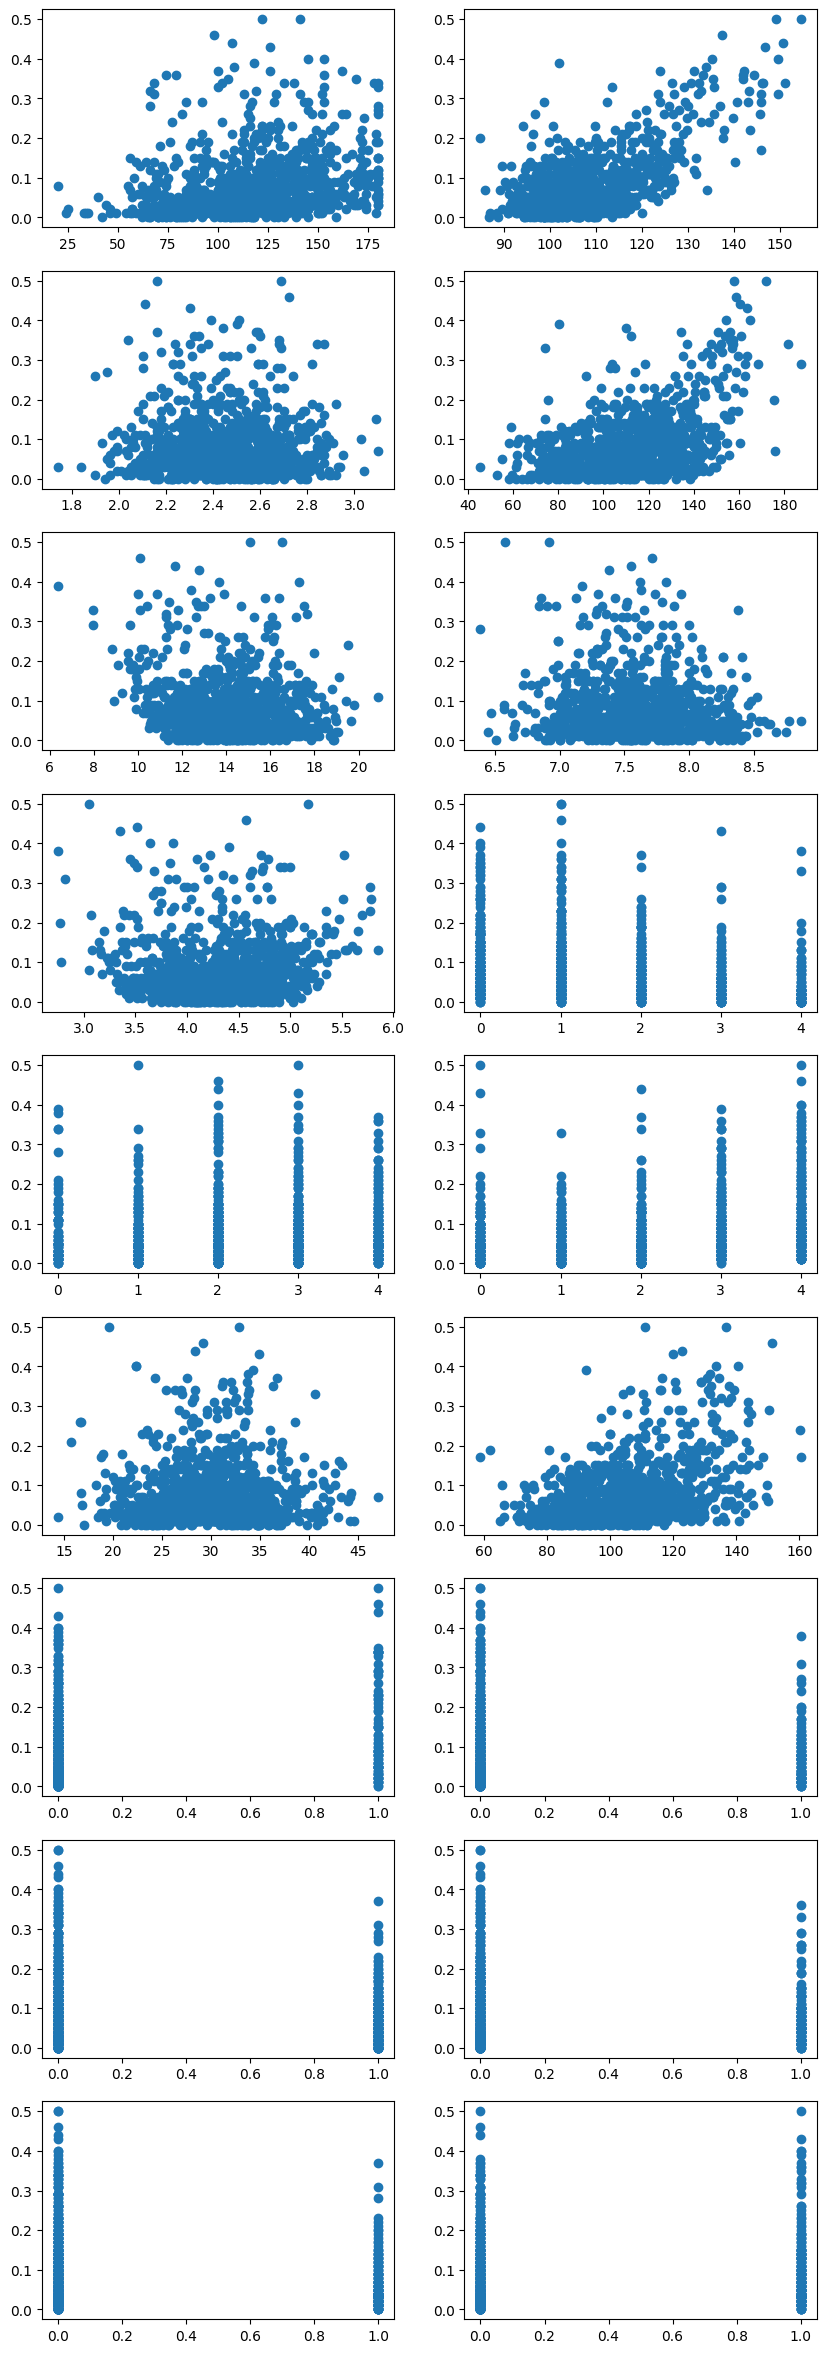

In [6]:
fig, axs = plt.subplots(9, 2, figsize=(10,30))

for index in range(18):
    axs[index//2,index%2].scatter(X_train[X_train.columns[index]],y_train)

		
print(np.unique(X_train["sarsaparilla"],return_counts=True))
print(np.unique(X_train["smurfberry liquor"],return_counts=True))
print(np.unique(X_train["smurfin donuts"],return_counts=True))

## Greedy search

In [7]:
#To evaluate teh greedy search
def evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features):
    
    # train model
    model.fit(X_train[selected_features].values, y_train.values.ravel())
    
    # evaluate model
    y_pred = model.predict(X_test[selected_features].values) 
    rmse = np.sqrt(np.mean((y_pred-y_test.values.ravel() )**2))
    
    print(f"selected features: ")
    for i,feature in enumerate(selected_features):
        print(f"- {feature}")
    print("----------------------------------")
    print(f"RMSE basic MLP: {rmse:5.3f}")

In [8]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

model = LinearRegression()
sfs = SequentialFeatureSelector(model,direction='backward')
sfs.fit(X_train,y_train)
selected_features = sfs.get_feature_names_out() # to modify

In [9]:
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)

selected features: 
- age
- blood pressure
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- weight
- resource extraction
----------------------------------
RMSE basic MLP: 0.055


## Without Greedy Search

In [10]:
model = LinearRegression()
selected_features = X_train.columns
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)

selected features: 
- age
- blood pressure
- calcium
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- smurfin donuts
- vitamin D
- weight
- administration and governance
- craftsmanship
- food production
- manufacturing
- resource extraction
- services
----------------------------------
RMSE basic MLP: 0.056


## Model Selection (Polynomial search)

In [11]:
from sklearn.preprocessing import PolynomialFeatures


model = LinearRegression()


for degree in [1, 2, 3]:
    print(f"=== Polynomial Degree {degree} ===")
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out(X_train.columns))
    X_test_poly = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out(X_train.columns))

    # Perform backward feature selection
    sfs = SequentialFeatureSelector(model, direction='backward')
    sfs.fit(X_train_poly, y_train)

    selected_features = sfs.get_feature_names_out()
    
    # Evaluate
    evaluate_feature_selection(X_train_poly, X_test_poly, y_train, y_test, model, selected_features)

=== Polynomial Degree 1 ===
selected features: 
- age
- blood pressure
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- weight
- resource extraction
----------------------------------
RMSE basic MLP: 0.055
None
=== Polynomial Degree 2 ===


KeyboardInterrupt: 